# 1. Понимание бизнеса


## 1.1 Цель
Предсказать качество вина

## 1.2 Описание
Датасет представляет из себя набор характеристик португальского вина виньо верде (так называемое зеленое вино), которое может быть как белым, так и красным. В связи с конфиденциальностью инофрмации доступны только физико-химические  и сенсорные переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.). 

# 2. Data Understanding

## 2.1 Import Libraries
Импортируем необходимые библиотеки

In [8]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 6 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = verde.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Import Dataset
Импортируем данные и смотрим различные характеристики вин

In [3]:
verde = pd.read_csv("E:\\Python\\ZAK-5\\winequalityN.csv")

In [4]:
verde.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
verde.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3475,white,6.2,0.36,0.45,10.4,0.060,22.0,184.0,0.99711,3.31,0.56,9.8,6
1291,white,7.5,0.23,0.32,9.2,0.038,54.0,191.0,0.99660,3.04,0.56,9.7,6
1441,white,7.2,0.31,0.24,1.4,0.057,17.0,117.0,0.99280,3.16,0.35,10.5,5
4325,white,6.4,0.24,0.26,8.2,0.054,47.0,182.0,0.99538,3.12,0.50,9.5,5
549,white,7.2,0.46,0.65,10.4,0.050,76.0,192.0,0.99760,3.16,0.42,8.7,5


In [6]:
verde['type'].value_counts()

white    4898
red      1599
Name: type, dtype: int64

Тепловая карта корреляции может дать нам понимание того, какие переменные важны

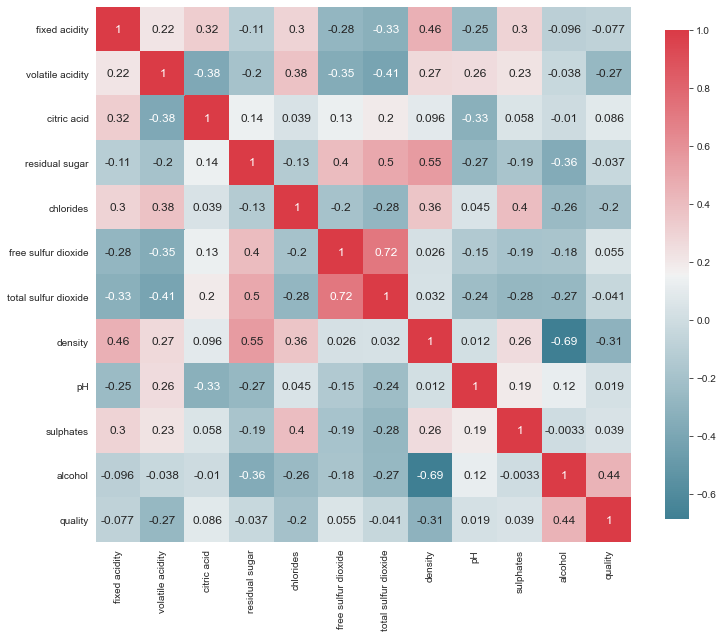

In [9]:
plot_correlation_map(verde)

Рассмотрим взаимосвязи между содержанием алкоголя и качеством вина.

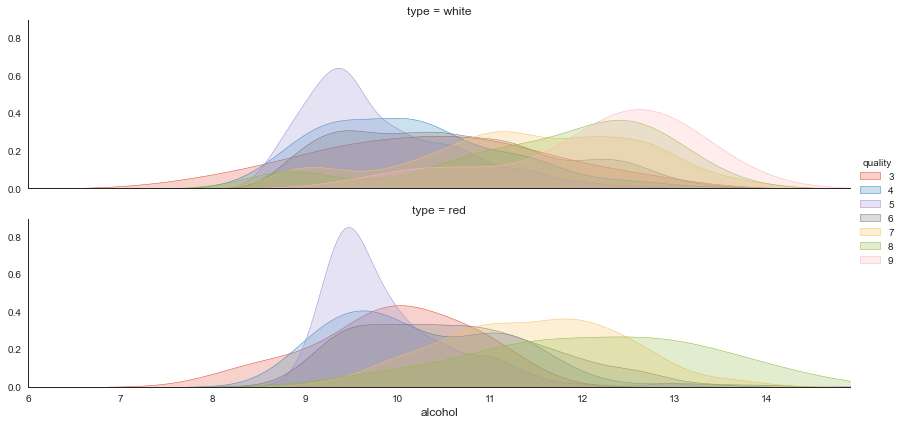

In [10]:
plot_distribution( verde , var = 'alcohol' , target = 'quality' , row = 'type' )

Мы также можем посмотреть на категориальные переменные, такой как тип вина и его связь с качеством

C:\Users\SD\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


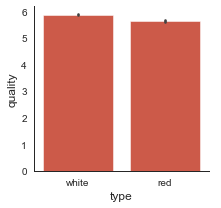

In [11]:
plot_categories( verde , cat = 'type' , target = 'quality' )

# 3. Data Preparation

## 3.1 Заполнить пропущенные значения в переменных
Смотрим, в каких столбцах в датасете нулевые значения

In [12]:
verde.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [13]:
#Replacing null values in fixed acidity with median
verde['fixed acidity'].fillna(verde['fixed acidity'].median(), inplace=True)
verde['volatile acidity'].fillna(verde['volatile acidity'].median(), inplace=True)
verde['citric acid'].fillna(verde['citric acid'].median(), inplace=True)
verde['residual sugar'].fillna(verde['residual sugar'].median(), inplace=True)
verde['chlorides'].fillna(verde['chlorides'].median(), inplace=True)
verde['pH'].fillna(verde['pH'].median(), inplace=True)
verde['sulphates'].fillna(verde['sulphates'].median(), inplace=True)

In [14]:
verde.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## 3.2 Удаление выбросов

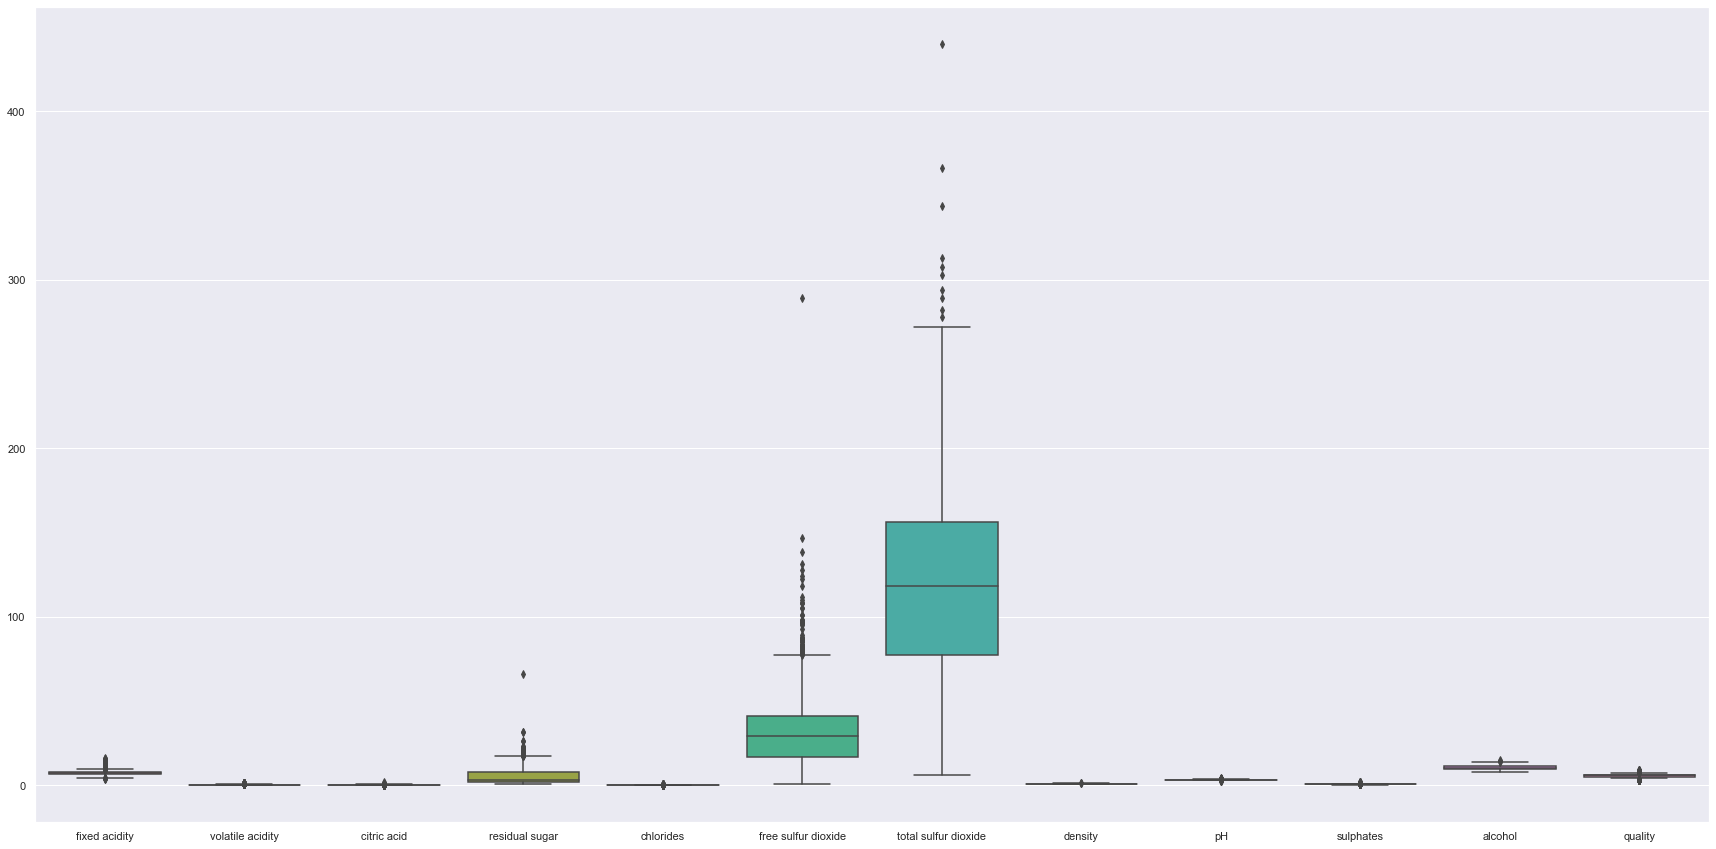

In [15]:
sns.set()
plt.figure(figsize=(30,15))
sns.boxplot(data=verde)
plt.show()

C:\Users\SD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\SD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\SD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


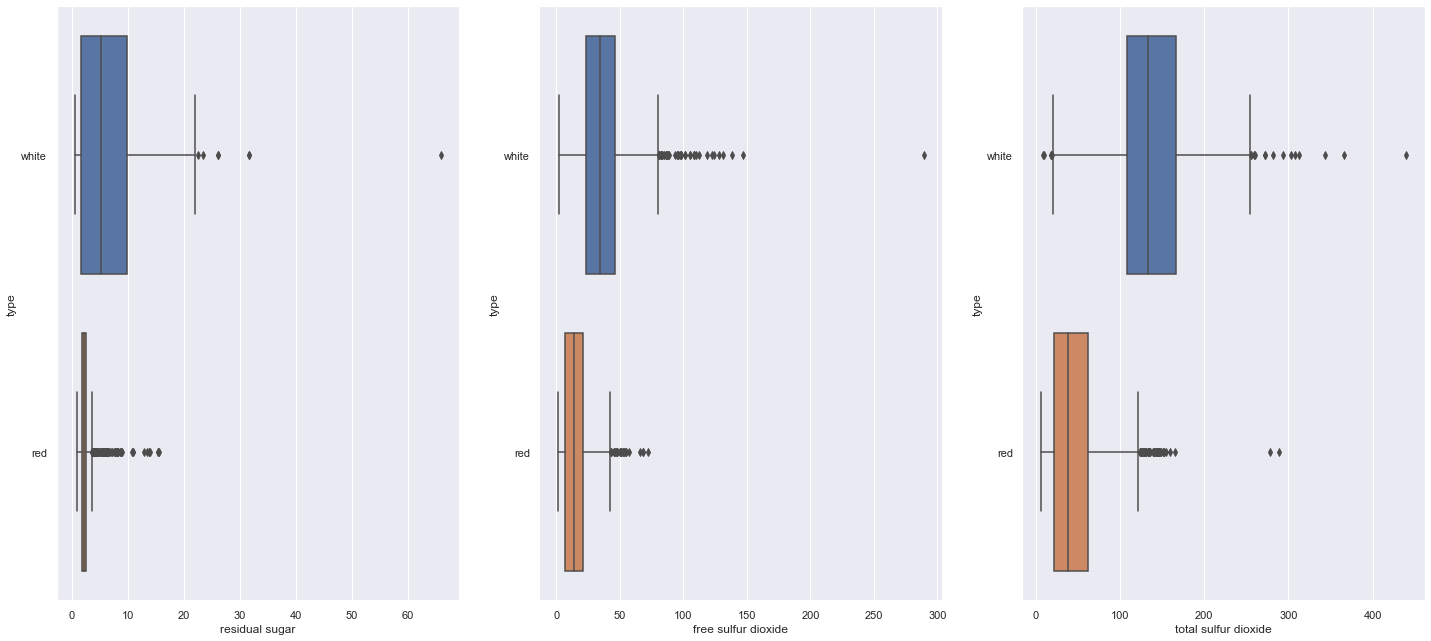

In [16]:
fig, ax =plt.subplots(1,3)
plt.subplots_adjust(right=2.5, top=1.5)
sns.boxplot(verde['residual sugar'], verde['type'], ax=ax[0])
sns.boxplot(verde['free sulfur dioxide'], verde['type'], ax=ax[1])
sns.boxplot(verde['total sulfur dioxide'], verde['type'], ax=ax[2])
plt.show()

Удаляем видимые выбросы

In [17]:
#Removing outliers in residual sugar
lower = verde['residual sugar'].mean()-3*verde['residual sugar'].std()
upper = verde['residual sugar'].mean()+3*verde['residual sugar'].std()
verde = verde[(verde['residual sugar']>lower) & (verde['residual sugar']<upper)]

#Removing outliers in free sulfur dioxide
lower = verde['free sulfur dioxide'].mean()-3*verde['free sulfur dioxide'].std()
upper = verde['free sulfur dioxide'].mean()+3*verde['free sulfur dioxide'].std()
verde = verde[(verde['free sulfur dioxide']>lower) & (verde['free sulfur dioxide']<upper)]

#Removing outliers in total sulfur dioxide
lower = verde['total sulfur dioxide'].mean()-3*verde['total sulfur dioxide'].std()
upper = verde['total sulfur dioxide'].mean()+3*verde['total sulfur dioxide'].std()
verde = verde[(verde['total sulfur dioxide']>lower) & (verde['total sulfur dioxide']<upper)]

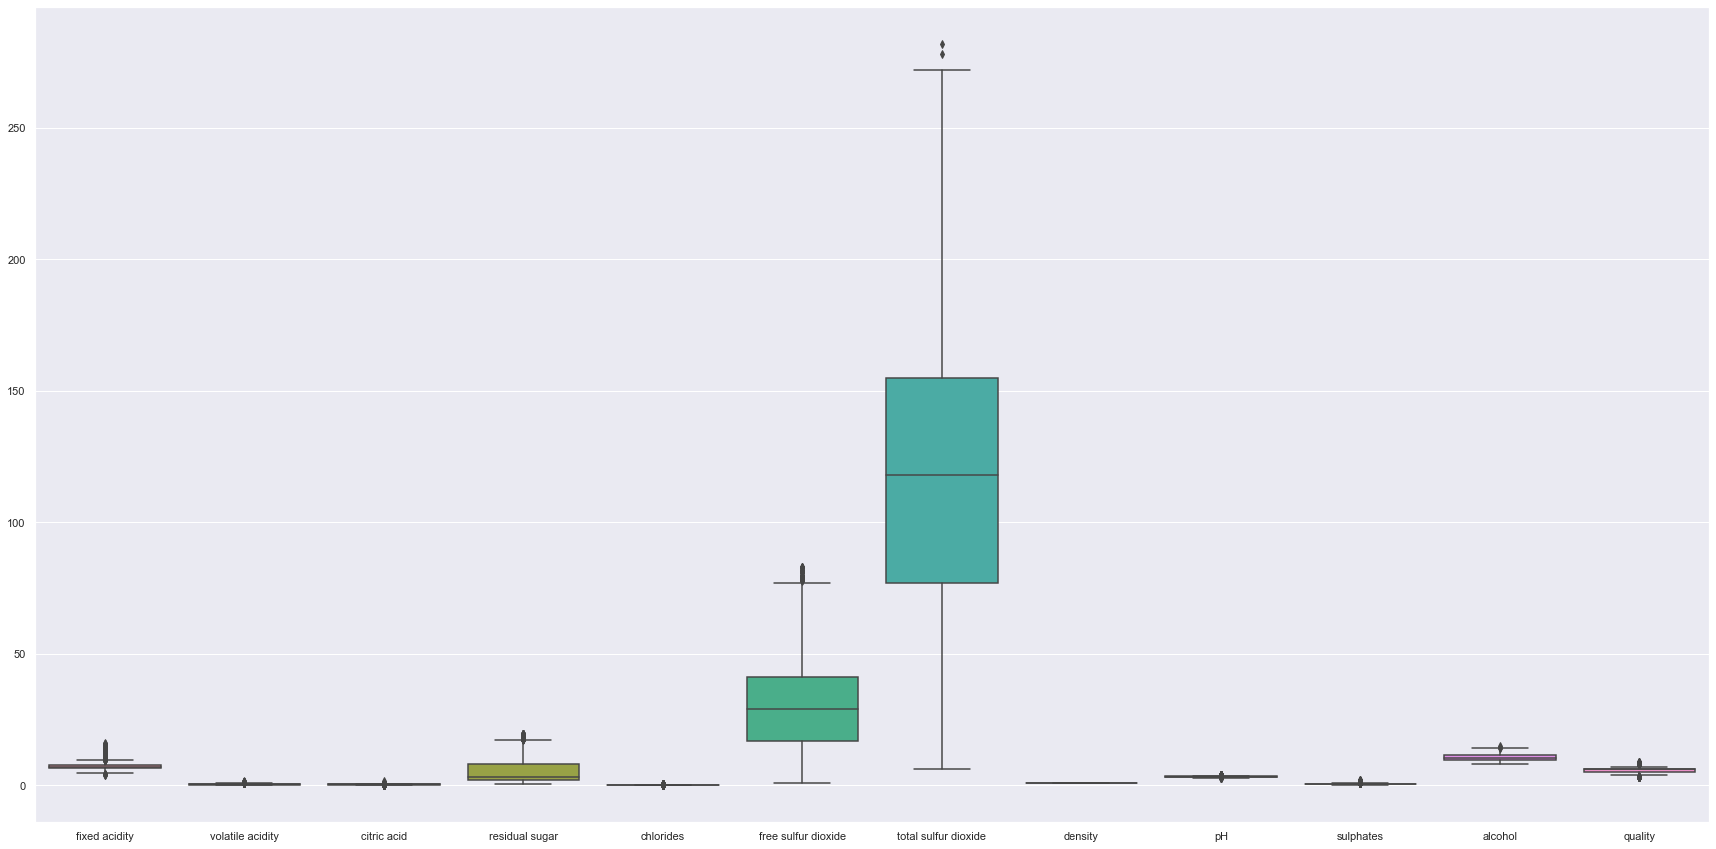

In [18]:
sns.set()
plt.figure(figsize=(30,15))
sns.boxplot(data=verde)
plt.show()

## 3.3 Категориальные переменные должны быть преобразованы в числовые переменные
OneHotEncoding для столбца type.

In [19]:
dummies = pd.get_dummies(verde['type'], drop_first=True)
verde = pd.concat([verde, dummies], axis=1)
verde.drop('type', axis=1, inplace=True)

## 3.4 Разделение на train и test

In [20]:
X = verde.loc[:,verde.columns!='quality']
y = verde['quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state=0)

# 4. Моделирование

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [21]:
model = LogisticRegression()

Также попробуем модель случйного леса

In [22]:
model2=RandomForestClassifier()

## 4.2 Обучение модели

In [23]:
model.fit( X_train, y_train )

C:\Users\SD\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
model2.fit( X_train, y_train )

RandomForestClassifier()

# 5. Оценка
Теперь мы собираемся оценить модель

In [25]:
y_pred=model.predict(X_test)
accuracy_score(y_test,y_pred)

0.4860031104199067

In [26]:
y_pred=model2.predict(X_test)
accuracy_score(y_test,y_pred)

0.7107309486780715

# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [27]:
y_test = model2.predict( X_test )
test = pd.DataFrame( { 'quality': y_test } )
test.shape
test.head()
test.to_csv( 'verde_pred.csv' , index = False )